In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [108]:
######################
# METADATA
######################
input_folder = r'C:\Users\A4023862\OneDrive - Astellas Pharma Inc\ForecastAI\data\mi_prod\inputs'
input_file = 'data_prep_cash_model.csv'
path = os.path.join(input_folder, input_file)

######################
# READ IN DATA
######################
raw1=pd.read_csv(path)
raw2=raw1[(raw1['LC']=='JPY - Japan Yen') & (raw1['Cost Objects']=='D_DE - Germany') & (raw1['Product PC']=='P_XOS_TOT - Xospata total')]

,tag,LC,Cost Objects,Product PC,value,ds,data_periods,short_history,no_sales,theta_check
33800,JPY - Japan Yen_D_DE - Germany_P_XOS_TOT - Xos...,JPY - Japan Yen,D_DE - Germany,P_XOS_TOT - Xospata total,0.000000e+00,2014-04-01,33,0.0,0.0,1.0
33801,JPY - Japan Yen_D_DE - Germany_P_XOS_TOT - Xos...,JPY - Japan Yen,D_DE - Germany,P_XOS_TOT - Xospata total,0.000000e+00,2014-05-01,33,0.0,0.0,1.0
33802,JPY - Japan Yen_D_DE - Germany_P_XOS_TOT - Xos...,JPY - Japan Yen,D_DE - Germany,P_XOS_TOT - Xospata total,0.000000e+00,2014-06-01,33,0.0,0.0,1.0
33803,JPY - Japan Yen_D_DE - Germany_P_XOS_TOT - Xos...,JPY - Japan Yen,D_DE - Germany,P_XOS_TOT - Xospata total,0.000000e+00,2014-07-01,33,0.0,0.0,1.0
33804,JPY - Japan Yen_D_DE - Germany_P_XOS_TOT - Xos...,JPY - Japan Yen,D_DE - Germany,P_XOS_TOT - Xospata total,0.000000e+00,2014-08-01,33,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
33995,JPY - Japan Yen_D_DE - Germany_P_XTD_TOT - Xta...,JPY - Japan Yen,D_DE - Germany,P_XTD_TOT - Xtandi Total,4.644868e+09,2022-03-01,100,0.0,0.0,1.0
33996,JPY - Japan Yen_D_DE - Germany_P_XTD_TOT - Xta...,JPY - Japan Yen,D_DE - Germany,P_XTD_TOT - Xtandi Total,4.828314e+09,2022-04-01,100,0.0,0.0,1.0
33997,JPY - Japan Yen_D_DE - Germany_P_XTD_TOT - Xta...,JPY - Japan Yen,D_DE - Germany,P_XTD_TOT - Xtandi Total,4.117436e+09,2022-05-01,100,0.0,0.0,1.0
33998,JPY - Japan Yen_D_DE - Germany_P_XTD_TOT - Xta...,JPY - Japan Yen,D_DE - Germany,P_XTD_TOT - Xtandi Total,4.231692e+09,2022-06-01,100,0.0,0.0,1.0


13:00:53 - cmdstanpy - INFO - Chain [1] start processing
13:00:54 - cmdstanpy - INFO - Chain [1] done processing


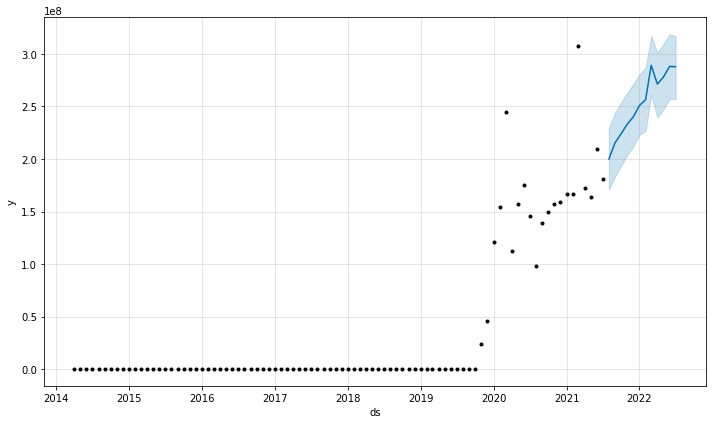

In [50]:
#############################
# BASELINE - PROPHET
#############################
# Inputs
periodsToForecast=12

# Prep data for Prophet
raw3=raw2[['ds', 'value']]
raw3 = raw3.rename(columns={'value': 'y'})
raw3 = raw3.sort_values(by='ds')
raw4=raw3.head(len(raw3)-periodsToForecast)

# Get last x actuals
actuals=raw3.tail(periodsToForecast)

# prophetを実行する関数を作成
def run_prophet(train, test):
    """
    input: dataframe train, dataframe test
    output: dataframe ouput, float mape, float error
    """

    m = Prophet()

    # fitメソッドを用いて、データセットをモデルに当てはめ
    m.fit(train)

    # 予測期間(半年:180日分)を指定し、予測期間を含めた日付データを作成
    future = m.make_future_dataframe(periods=test.shape[0],freq='MS')
    # 予測を実施
    forecast = m.predict(future)
    df_ = pd.concat([train,test])
    
    # Ensure dates are dates
    forecast.ds = pd.to_datetime(forecast.ds)
    df_.ds = pd.to_datetime(df_.ds)
    df_val = pd.merge(forecast,df_[['ds','y']],on='ds',how='left')

    # 構成要素を描画
    fig = m.plot_components(forecast)
    
    # # テストデータの日付を日付型に変換し、予測値を結合
    test.ds = pd.to_datetime(test.ds)
    df_val = pd.merge(test,forecast[['ds','yhat']], on='ds', how='inner')
    # 精度算出
    mape = np.mean(np.abs((df_val.yhat - df_val.y) / df_val.y)) * 100
    rmse = np.sqrt(mean_squared_error(df_val.y, df_val.yhat))
    error = np.abs((df_val.yhat.sum() - df_val.y.sum()) / df_val.y.sum()) * 100
    error2 = np.abs(df_val.yhat.sum() - df_val.y.sum())
    error3 = np.mean(df_val.yhat) - np.mean(df_val.y)

    # 予測値と実績をdf_outputに格納
    df_output = pd.merge(forecast,df_[['ds','y']], on='ds', how='left')
    df_output = df_output[['ds','y','trend','yearly','yhat','yhat_upper','yhat_lower']].copy()
    df_output.rename(columns={'ds':"年月",'y':"実績",'trend':"トレンド",'yearly':"周期性",'yhat':"予測",'yhat_upper':"予測上限",'yhat_lower':"予測下限"},inplace=True)

    output = dict(
        model = 'Prophet',
        df = df_output.copy(),
        fig = fig,
        mape = mape,
        rmse = rmse,
        error = error,
        error2 = error2,
        error3 = error3
    )
    return output

output=run_prophet(raw4, actuals)
output

C:\Users\A4023862\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'model': 'state-space model',
 'df':            ds            y         level         trend    seasonality  \
 0  2014-04-01          0.0     -0.000161     -0.000156       0.001259   
 1  2014-05-01          0.0  -1883.714731  20997.153870  131846.756840   
 2  2014-06-01          0.0  19360.154111 -45871.130060  -43199.262798   
 3  2014-07-01          0.0 -26655.045440 -61430.290443   14313.833177   
 4  2014-08-01          0.0 -88431.709667  46368.625041   95667.229909   
 ..        ...          ...           ...           ...            ...   
 95 2022-03-01  188631353.3           NaN           NaN            NaN   
 96 2022-04-01  128442440.1           NaN           NaN            NaN   
 97 2022-05-01  148052944.0           NaN           NaN            NaN   
 98 2022-06-01  129872468.7           NaN           NaN            NaN   
 99 2022-07-01  176415170.1           NaN           NaN            NaN   
 
             yhat       lower y       upper y  
 0   0.000000e+00 -3.4255

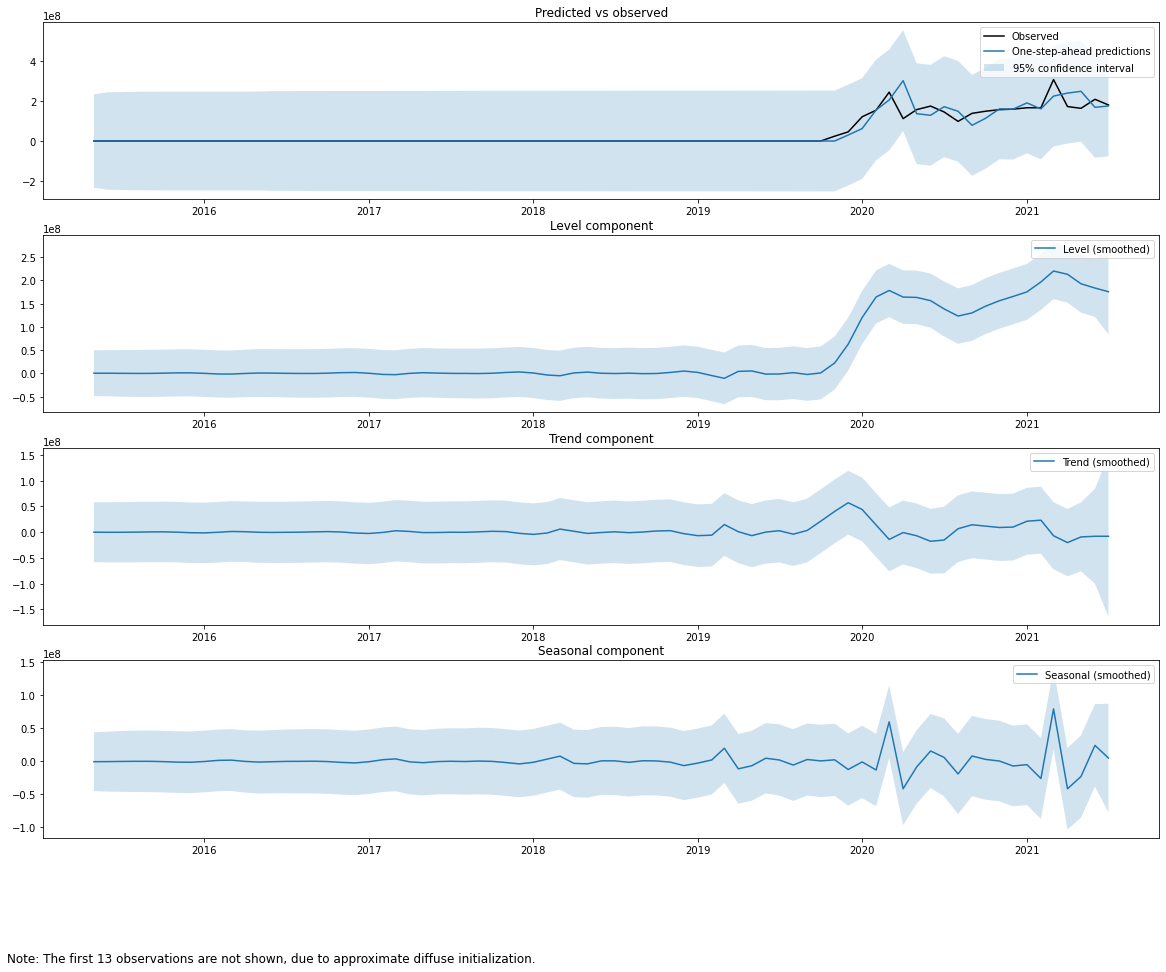

In [88]:
#############################
# STATE SPACE MODEL
#############################
import statsmodels.api as sm
from matplotlib.pyplot import rcParams

def run_ssm(train, test, share=False):
    """
    input: dataframe train, dataframe test, bool share
    output: dict{dataframe ouput, float mape, float error}
    """
    
    train = train.set_index('ds')
    test = test.set_index('ds')

    # Set confidence interval (1 - ALPHA)
    # prophet
    ALPHA = 0.2
    
    # Specify model
    if share:
        mod_llt = sm.tsa.UnobservedComponents(train,
                                              'local linear trend',
#                                               seasonal=12
                                             )
    else:
        mod_llt = sm.tsa.UnobservedComponents(train,
                                              'local linear trend',
                                              seasonal=12
                                             )
        
    # Parameter estimation
    res_llt = mod_llt.fit()
    
    # Drawing of components
    rcParams['figure.figsize'] = 20,15  
    fig = res_llt.plot_components()
    
    # Combine predicted values with test data
    forecast = res_llt.get_forecast(test.shape[0])
    test['yhat'] = forecast.predicted_mean
        
    # Combine state, trend, and periodicity with actual data from fitting results
    df_output_train = train.copy()
    df_output_train['level'] = res_llt.level['smoothed']
    df_output_train['trend'] = res_llt.trend['smoothed']
    try:
        df_output_train['seasonality'] = res_llt.seasonal['smoothed']
    except:
        df_output_train['seasonality'] = np.nan
        
    # Combine predicted values (upper and lower limits) with actual data from fitting results
    prediction = res_llt.get_prediction()
    df_output_train['yhat'] = prediction.predicted_mean
    df_output_train = df_output_train.join(prediction.conf_int(alpha=ALPHA))
    
    # Combine the predicted values (upper and lower limits) of the test period with the actual data
    df_output_test = test.copy()
    df_output_test = df_output_test.join(forecast.summary_frame()[['mean_ci_lower', 'mean_ci_upper']], how='left')
    df_output_test.columns = ['y', 'yhat', 'lower y', 'upper y']
    
    # output
    df_output = pd.concat([df_output_train, df_output_test]).reset_index()

    # Accuracy calculation
    mape = np.mean(np.abs((test.yhat - test.y) / test.y)) * 100
    rmse = np.sqrt(mean_squared_error(test.y, test.yhat))
    error = np.abs((test.yhat.sum() - test.y.sum()) / test.y.sum()) * 100
    error2 = np.abs(test.yhat.sum() - test.y.sum())
    error3 = np.mean(test.yhat) - np.mean(test.y)
    
    output = dict(
        model = 'state-space model',
        df = df_output.copy(),
        fig = fig,
        mape = mape,
        rmse = rmse,
        error = error,
        error2 = error2,
        error3 = error3
    )
    
    return output

output=run_ssm(raw4, actuals, share=False)
output

In [ ]:
# NEW VERSION

# prophetを実行する関数を作成
def run_prophet(id, train, test):
    """
    input: dataframe train, dataframe test
    output: dataframe ouput, float mape, float error
    """

    m = Prophet()

    # fitメソッドを用いて、データセットをモデルに当てはめ
    m.fit(train)

    # 予測期間(半年:180日分)を指定し、予測期間を含めた日付データを作成
    future = m.make_future_dataframe(periods=test.shape[0],freq='MS')
    # 予測を実施
    forecast = m.predict(future)
    df_ = pd.concat([train,test])
    
    # Ensure dates are dates
    forecast.ds = pd.to_datetime(forecast.ds)
    df_.ds = pd.to_datetime(df_.ds)
    df_val = pd.merge(forecast,df_[['ds','y']],on='ds',how='left')

    # 構成要素を描画
    fig = m.plot_components(forecast)
    
    # # テストデータの日付を日付型に変換し、予測値を結合
    test.ds = pd.to_datetime(test.ds)
    df_val = pd.merge(test,forecast[['ds','yhat']], on='ds', how='inner')
    # 精度算出
    mape = np.mean(np.abs((df_val.yhat - df_val.y) / df_val.y)) * 100
    rmse = np.sqrt(mean_squared_error(df_val.y, df_val.yhat))
    error = np.abs((df_val.yhat.sum() - df_val.y.sum()) / df_val.y.sum()) * 100
    error2 = np.abs(df_val.yhat.sum() - df_val.y.sum())
    error3 = np.mean(df_val.yhat) - np.mean(df_val.y)

    # 予測値と実績をdf_outputに格納
    df_output = pd.merge(forecast,df_[['ds','y']], on='ds', how='left')
    df_output = df_output[['ds','y','trend','yearly','yhat','yhat_upper','yhat_lower']].copy()
    df_output.rename(columns={'ds':"年月",'y':"実績",'trend':"トレンド",'yearly':"周期性",'yhat':"予測",'yhat_upper':"予測上限",'yhat_lower':"予測下限"},inplace=True)

    output = dict(
        id = id,
        model = 'prophet',
        df = df_output.copy(),
        fig = fig,
        mape = mape,
        rmse = rmse,
        error = error,
        error2 = error2,
        error3 = error3
    )
    return output

def run_ssm(id, train, test, share=False):
    """
    input: dataframe train, dataframe test, bool share
    output: dict{dataframe ouput, float mape, float error}
    """
    
    train = train.set_index('ds')
    test = test.set_index('ds')

    # Set confidence interval (1 - ALPHA)
    # prophet
    ALPHA = 0.2
    
    # Specify model
    if share:
        mod_llt = sm.tsa.UnobservedComponents(train,
                                              'local linear trend',
#                                               seasonal=12
                                             )
    else:
        mod_llt = sm.tsa.UnobservedComponents(train,
                                              'local linear trend',
                                              seasonal=12
                                             )
        
    # Parameter estimation
    res_llt = mod_llt.fit()
    
    # Drawing of components
    rcParams['figure.figsize'] = 20,15  
    fig = res_llt.plot_components()
    
    # Combine predicted values with test data
    forecast = res_llt.get_forecast(test.shape[0])
    test['yhat'] = forecast.predicted_mean
        
    # Combine state, trend, and periodicity with actual data from fitting results
    df_output_train = train.copy()
    df_output_train['level'] = res_llt.level['smoothed']
    df_output_train['trend'] = res_llt.trend['smoothed']
    try:
        df_output_train['seasonality'] = res_llt.seasonal['smoothed']
    except:
        df_output_train['seasonality'] = np.nan
        
    # Combine predicted values (upper and lower limits) with actual data from fitting results
    prediction = res_llt.get_prediction()
    df_output_train['yhat'] = prediction.predicted_mean
    df_output_train = df_output_train.join(prediction.conf_int(alpha=ALPHA))
    
    # Combine the predicted values (upper and lower limits) of the test period with the actual data
    df_output_test = test.copy()
    df_output_test = df_output_test.join(forecast.summary_frame()[['mean_ci_lower', 'mean_ci_upper']], how='left')
    df_output_test.columns = ['y', 'yhat', 'lower y', 'upper y']
    
    # output
    df_output = pd.concat([df_output_train, df_output_test]).reset_index()

    # Accuracy calculation
    mape = np.mean(np.abs((test.yhat - test.y) / test.y)) * 100
    rmse = np.sqrt(mean_squared_error(test.y, test.yhat))
    error = np.abs((test.yhat.sum() - test.y.sum()) / test.y.sum()) * 100
    error2 = np.abs(test.yhat.sum() - test.y.sum())
    error3 = np.mean(test.yhat) - np.mean(test.y)
    
    output = dict(
        id = id,
        model = 'state-space model',
        df = df_output.copy(),
        fig = fig,
        mape = mape,
        rmse = rmse,
        error = error,
        error2 = error2,
        error3 = error3
    )
    
    return output

# 将来予測：線形ガウス型状態空間モデルを実行する関数を作成
def run_ssm_forecast(id, train, test, n, share=False):
    """
    input: dataframe train, dataframe test, int n, bool share
    output: dataframe ouput
    """
    
    train = train.set_index('ds')
    test = test.set_index('ds')

    # 信頼区間を設定(1 - ALPHA)
    # prophetのデフォルト値
    ALPHA = 0.2

    # 学習データとテストデータを結合
    df_all = pd.concat([train, test])
    
    # Specify model
    if share:
        mod_llt = sm.tsa.UnobservedComponents(df_all,
                                              'local linear trend',
#                                               seasonal=12
                                             )
    else:
        mod_llt = sm.tsa.UnobservedComponents(df_all,
                                              'local linear trend',
                                              seasonal=12
                                             )

    # Parameter estimation
    res_llt = mod_llt.fit()

    # Drawing of components
    rcParams['figure.figsize'] = 20,15  
    fig = res_llt.plot_components()

    # フィッティング結果を取得
    prediction = res_llt.get_prediction()

    # フィッティング結果から、状態・トレンド・周期性を実績データに結合
    df_all['level'] = res_llt.level['smoothed']
    df_all['trend'] = res_llt.trend['smoothed']
    try:
        df_all['seasonality'] = res_llt.seasonal['smoothed']
    except:
        df_all['seasonality'] = np.nan
    # フィッティング結果から、予測値（上限、下限）を実績データに結合
    df_all['yhat'] = prediction.predicted_mean
    df_all = df_all.join(prediction.conf_int(alpha=ALPHA))
    # カラム名変更
    # df_all.rename(columns={'y':'実績', 'lower y':'予測下限', 'upper y':'予測上限'}, inplace=True)
      
    # 将来の予測値を取得
    forecast = res_llt.get_forecast(n)
    df_future = pd.DataFrame(forecast.predicted_mean)
    # 予測上限・下限を取得
    df_future = df_future.join(forecast.summary_frame()[['mean_ci_lower', 'mean_ci_upper']], how='left')
    # カラム名変更
    df_future.columns = ['yhat', 'lower y', 'upper y']

    # outputを結合
    df_output = pd.concat([df_all, df_future]).reset_index()
    # df_output.rename(columns={'index':'年月'}, inplace=True)
    
    output = dict(
        id = id,
        model = 'state-space model',
        df = df_output.copy(),
        fig = fig,
    )
    
    return output 

######################
# DATA PREP FOR MULTIPLE TAGS
######################
raw2=raw1[(raw1['LC']=='JPY - Japan Yen')]
# raw2=raw1[(raw1['LC']=='JPY - Japan Yen') & (raw1['Cost Objects']=='D_DE - Germany') & (raw1['Product PC'].isin(['P_XOS_TOT - Xospata total', 'P_XTD_TOT - Xtandi Total']))]
# raw2=raw1[(raw1['LC']=='JPY - Japan Yen') & (raw1['Cost Objects']=='D_DE - Germany') & (raw1['Product PC'].isin(['P_XOS_TOT - Xospata total']))]

# Parameters
hdt_months=12
fct_months=24
output_df=pd.DataFrame(columns=['id','model', 'rmse', 'error2'])

# <- Start Loop HERE
for i in range(len(raw2['tag'].unique())):
    # Get tag
    tag=raw2['tag'].unique()[i]
    
    # Prep data
    raw3=raw2[raw2['tag']==tag][['ds', 'value']]
    raw3 = raw3.rename(columns={'value': 'y'})
    raw3 = raw3.sort_values(by='ds')
    raw4=raw3.head(len(raw3)-hdt_months)
    
    # Get last x actuals
    actuals=raw3.tail(hdt_months)   

    ###################
    # HDT
    ###################
    hdt1=run_ssm(id=tag, train=raw4, test=actuals, share=False)
    hdt2=run_prophet(id=tag, train=raw4, test=actuals)

    # ###################
    # # FCT
    # ###################
    # fct1=run_ssm_forecast(id=tag, train=raw4, test=actuals, n=fct_months, share=False)
    

    ###################
    # SELECT WINNER
    ###################
    winner_keys = ('id', 'model', 'rmse', 'error2')

    competitor1 = {x: hdt1[x] for x in interesting_keys if x in hdt1}
    competitor1=pd.DataFrame.from_dict(competitor1, orient='index')
    
    competitor2 = {x: hdt2[x] for x in interesting_keys if x in hdt2}
    competitor2=pd.DataFrame.from_dict(competitor2, orient='index')

    # Stack results
    competitors=pd.concat([competitor1.T, competitor2.T])
    
    # Get model with miumum RMSE
    winners=competitors[competitors['rmse'].isin(competitors.groupby('id').min()['rmse'].values)]
    
    # Append to sales df
    output_df = output_df.append(winners, ignore_index=True)

output_df

C:\Users\A4023862\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
17:22:32 - cmdstanpy - INFO - Chain [1] start processing
17:22:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\A4023862\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
17:22:34 - cmdstanpy - INFO - Chain [1] start processing
17:22:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\A4023862\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
17:22:37 - cmdstanpy - INFO - Chain [1] start processing
17:22:37 - cmdstanpy - INFO - Chain 

In [185]:
print(len(output_df[output_df['model']=='prophet']))
print(len(output_df[output_df['model']=='state-space model']))
output_df.to_csv(r"C:\Users\A4023862\OneDrive - Astellas Pharma Inc\ForecastAI\data\mi_prod\outputs\output_df.csv")

611
536
